In [1]:
import pypsa 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Einlesen der Datenreihen

In [2]:
# Erzeugung durch Erneuerbare
data_pv = pd.read_csv('data/data_pv_antofagasta_1MW.csv', skiprows = 3)['electricity']/1000
data_wind = pd.read_csv('data/data_wind_antofagasta_1MW.csv', skiprows = 3)['electricity']/1000
data_electrolysis = pd.read_excel('data/load_electrolysis.xlsx')['hydrogen']
data_shipping_1 = pd.read_excel('data/Ferntransport.xlsx')['Kapazität [MWh]']
data_shipping_2 = 0

In [3]:
# Inputs Variablen

data_inputs = pd.read_excel('data/Inputs_Modell.xlsx', sheet_name = 'Gesamt', header = 2, index_col = 0)


In [4]:
# Erstellung Last
hydrogen_energy_content = 33 #kWh/kg
hydrogen_demand = (35 * 1000) * hydrogen_energy_content # MWh
hydrogen_demand_hourly = hydrogen_demand/8760 #MW

print('Der stündliche Bedarf bei konstanter Verteilung des Jahresbedarfs von 35 kt Wasserstoff beträgt ungefähr ' + str(round(hydrogen_demand_hourly,0)) + ' MWh')

#Erstellung Elektrolyseprofil

Der stündliche Bedarf bei konstanter Verteilung des Jahresbedarfs von 35 kt Wasserstoff beträgt ungefähr 132.0 MWh


In [5]:
hydrogen_demand_hourly

131.84931506849315

# Definition der Variablen

## Leistungen

In [6]:
p_nom_pv = data_pv.max()
p_nom_wind = data_wind.max()

## Investitionskosten

In [7]:
# generators
capital_cost_pv = 800 # €/MW
capital_cost_wind = 800 # €/MW

# links
capital_cost_PEMEL = data_inputs.loc['PEM Elektrolyse']['capital_cost'] # €/MW
capital_cost_AEL = data_inputs.loc['AEL Elektrolyse']['capital_cost'] # €/MW
#capital_cost_HTEL = 1300 # €/MW
capital_cost_NH3 = 1400 # €/MW
capital_cost_LH2 = data_inputs.loc['Verflüssigung']['capital_cost'] # €/MW
capital_cost_LHOC = 1600 # €/MW
capital_cost_pipeline = 5000 # €/MW
capital_cost_shipping_1 = 10000 # €/MW
capital_cost_shipping_2 = 80000 # €/MW

# storages
capital_cost_storage_GH2 = 200 # €/MW
capital_cost_storage_NH3 = 20 # €/MW
capital_cost_storage_LH2 = data_inputs.loc['LH2 Speicher']['capital_cost'] # €/MW
capital_cost_storage_LHOC = 20 # €/MW

## Gestehungskosten

In [8]:
# generators
marginal_cost_pv = 70 # €/MWh
marginal_cost_wind = 70 # €/MWh

# conversion
marginal_cost_PEMEL = data_inputs.loc['PEM Elektrolyse']['marginal_cost'] # €/MWh
marginal_cost_AEL = data_inputs.loc['AEL Elektrolyse']['marginal_cost'] # €/MWh
#marginal_cost_HTEL = 100 # €/MWh
marginal_cost_NH3 = 100 # €/MWh
marginal_cost_LH2 = data_inputs.loc['Verflüssigung']['marginal_cost'] # €/MWh
marginal_cost_LHOC = 100 # €/MWh

# storage
marginal_cost_storage_GH2 = 20 # €/MWh
marginal_cost_storage_NH3 = 20 # €/MWh
marginal_cost_storage_LH2 = 20 # €/MWh
marginal_cost_storage_LHOC = 20 # €/MWh

# transportation
marginal_cost_pipeline = 200 # €/MWh
marginal_cost_shipping_GH2 = 10 # €/MWh
marginal_cost_shipping_NH3 = 10 # €/MWh
marginal_cost_shipping_LH2 = data_inputs.loc['LH2 Speicher']['marginal_cost'] # €/MWh
marginal_cost_shipping_LHOC = 10 # €/MWh

## Sonstiges

In [9]:
# efficiencies
efficiency_PEMEL = data_inputs.loc['PEM Elektrolyse']['efficiency']
efficiency_AEL = data_inputs.loc['AEL Elektrolyse']['efficiency']
#efficiency_HTEL = 1
efficiency_NH3 = 1
efficiency_LH2 = data_inputs.loc['Verflüssigung']['efficiency']
efficiency_LHOC = 1

# lifetimes
lifetime_PEMEL = 20
lifetime_AEL = 20
#lifetime_HTEL = 20

# standing losses
standing_loss_GH2 = 0.05
standing_loss_NH3 = 0.05
standing_loss_LH2 = data_inputs.loc['LH2 Speicher']['standing_loss']
standing_loss_LHOC = 0.05

# Netzwerk aufbauen

In [10]:
network = pypsa.Network()
network.set_snapshots(range(8760))

## Buses

In [11]:
network.add('Bus', name = 'electricity')
network.add('Bus', name = 'GH2')
network.add('Bus', name = 'LH2')
#network.add('Bus', name = 'NH3')
#network.add('Bus', name = 'LH2')
#network.add('Bus', name = 'LHOC')
#network.add('Bus', name = 'hydrogen')

network.add('Bus', name = 'bremerhaven')
#network.add('Bus', name = 'cologne')

## Loads

In [12]:
network.add('Load', name = 'hydrogen_demand', bus = 'bremerhaven', p_set = hydrogen_demand_hourly)

## Generators

In [13]:
network.add('Generator', name = 'pv', bus = 'electricity', 
            p_nom = p_nom_pv, p_max_pu = data_pv/p_nom_pv, p_min_pu = data_pv/p_nom_pv, p_nom_extendable = True,
            marginal_cost = marginal_cost_pv, capital_cost = capital_cost_pv)

#network.add('Generator', name = 'pv', bus = 'electricity', 
#            p_nom = p_nom_pv, p_max_pu = data_pv/p_nom_pv, p_nom_extendable = True,
#            marginal_cost = marginal_cost_pv, capital_cost = capital_cost_pv)

network.add('Generator', name = 'wind', bus = 'electricity',
            p_nom = p_nom_wind, p_max_pu = data_wind/p_nom_wind, p_min_pu = data_wind/p_nom_wind, p_nom_extendable = True,
            marginal_cost = marginal_cost_wind, capital_cost = capital_cost_wind)

## Links - Electrolysis

In [14]:
network.add('Link', name = 'PEMEL', bus0 = 'electricity', bus1 = 'GH2', 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_PEMEL, capital_cost = capital_cost_PEMEL,
            efficiency = efficiency_PEMEL)


network.add('Link', name = 'AEL', bus0 = 'electricity', bus1 = 'GH2',
           p_nom_extendable = True,
           marginal_cost = marginal_cost_AEL, capital_cost = capital_cost_AEL,
           efficiency = efficiency_AEL)
network.add('Link', name = 'HTEL', bus0 = 'electricity', bus1 = 'GH2',
           p_nom_extendable = True,
           marginal_cost = marginal_cost_HTEL, capital_cost = capital_cost_HTEL,
           efficiency = efficiency_HTEL)

## Links - Conversion

In [15]:
network.add('Link', name = 'LH2', bus0 = 'GH2', bus1 = 'LH2',
           p_nom_extendable = True,
           marginal_cost = marginal_cost_LH2, capital_cost = capital_cost_LH2,
           efficiency = efficiency_LH2)

network.add('Link', name = 'NH3', bus0 = 'electricity', bus1 = 'NH3',
           p_nom_extendable = True,
           marginal_cost = marginal_cost_NH3, capital_cost = capital_cost_NH3,
           efficiency = efficiency_NH3)

network.add('Link', name = 'LHOC', bus0 = 'electricity', bus1 = 'LHOC',
           p_nom_extendable = True,
           marginal_cost = marginal_cost_LHOC, capital_cost = capital_cost_LHOC,
           efficiency = efficiency_LHOC)

## Links - Ferntransport

In [16]:
# long distance shipment
network.add('Link', name = 'Ferntransport_GH2', bus0 = 'LH2', bus1 = 'bremerhaven',
            p_nom = data_shipping_1.max(), p_max_pu = data_shipping_1/data_shipping_1.max(), p_nom_extendable = True,
            marginal_cost = marginal_cost_shipping_GH2, capital_cost = capital_cost_shipping_1)

network.add('Link', name = 'Ferntransport_NH3', bus0 = 'NH3', bus1 = 'bremerhaven',
            p_nom = data_shipping_1.max(), p_max_pu = data_shipping_1/data_shipping_1.max(),
            marginal_cost = marginal_cost_shipping_NH3)

network.add('Link', name = 'Ferntransport_LH2', bus0 = 'LH2', bus1 = 'bremerhaven',
            p_nom = data_shipping_1.max(), p_max_pu = data_shipping_1/data_shipping_1.max(),
            marginal_cost = marginal_cost_shipping_LH2)

network.add('Link', name = 'Ferntransport_LHOC', bus0 = 'LHOC', bus1 = 'bremerhaven',
            p_nom = data_shipping_1.max(), p_max_pu = data_shipping_1/data_shipping_1.max(),
            marginal_cost = marginal_cost_shipping_LHOC)


## Links - Pipeline

## Storages

In [17]:
network.add('Store', name = 'antofagasta_GH2', bus = 'GH2', 
            e_nom_extendable = True,  e_cyclic = True, 
            capital_cost = capital_cost_storage_GH2)

network.add('Store', name = 'hydrogen_store_1.1', bus = 'NH3', 
            e_nom_extendable = True,  e_cyclic = True, 
            capital_cost = capital_cost_storage_NH3)

network.add('Store', name = 'hydrogen_store_1.2', bus = 'LH2', 
            e_nom_extendable = True, e_cyclic = True,  
            capital_cost = capital_cost_storage_LH2)

network.add('Store', name = 'hydrogen_store_1.3', bus = 'LHOC', 
            e_nom_extendable = True, e_cyclic = True,  
            capital_cost = capital_cost_storage_LHOC)

network.add('Store', name = 'bremerhaven_GH2', bus = 'bremerhaven', 
            e_nom_extendable = True, e_cyclic = True, 
            capital_cost = capital_cost_storage_GH2)

network.add('Store', name = 'cologne_GH2', bus = 'cologne', 
            e_nom_extendable = True, e_cyclic = True, 
            capital_cost = capital_cost_storage_GH2)

# Optimierung des Systems

In [18]:
network.lopf(pyomo = False, solver_name = 'gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.22s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-01
Read LP format model from file /var/folders/np/fxyv4bts2s353fj5gdlrbgym0000gn/T/pypsa-problem-d68r9j9z.lp
Reading time = 0.66 seconds
obj: 280320 rows, 148932 columns, 543534 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 280320 rows, 148932 columns and 543534 nonzeros
Model fingerprint: 0x0a491174
Coefficient statistics:
  Matrix range     [1e-06, 1e+00]
  Objective range  [1e+00, 3e+06]
  Bounds range     [2e+10, 2e+10]
  RHS range        [1e+02, 1e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 224049 rows and 127614 columns
Presolve time: 0.86s
Presolved: 56271 rows, 21318 columns, 157004 nonze

INFO:pypsa.linopf:Optimization successful. Objective value: -1.70e+10


('ok', 'optimal')

# Auswertung der Ergebnisse

In [19]:
def Jahresverlauf (Titel, Zeitstempel, Leistung, xlabel, ylabel):

  fig = plt.figure(figsize=(25,10))

 

  ax1 = fig.add_axes([1, 1, 1, 1])
  ax1.set_title(Titel,weight='bold',fontsize=15)
  ax1.plot(Zeitstempel,Leistung,c='green')
  plt.xlabel(xlabel,fontsize=15 )
  plt.ylabel(ylabel,fontsize=15)

 

  plt.show()

In [20]:
#Jahresverlauf('Stromerzeugung aus Windkraft',data_wind.time, data_wind['electricity'],'Zeit','Leistung')

In [21]:
network.generators.p_nom_opt

Generator
pv      780.169058
wind     40.333411
Name: p_nom_opt, dtype: float64

<AxesSubplot:xlabel='snapshot', ylabel='Leistung in MW'>

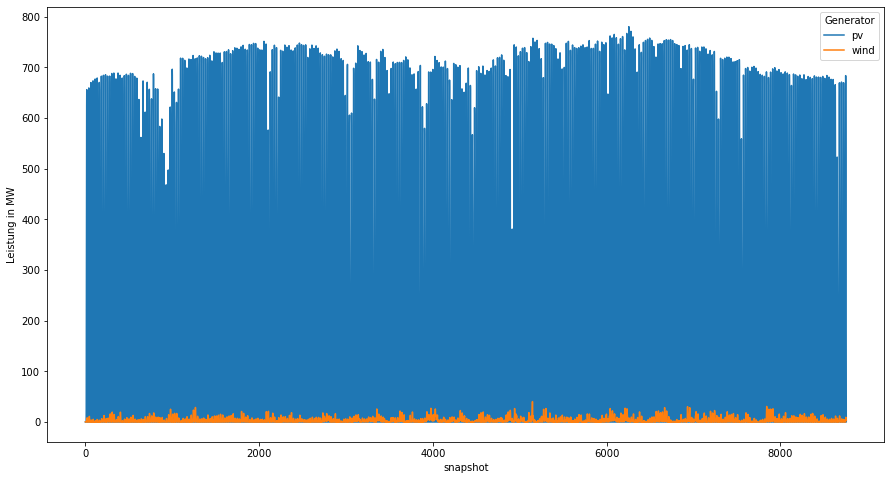

In [22]:
(network.generators_t.p).plot(figsize = (15,8), ylabel = 'Leistung in MW')

In [23]:
network.links.p_nom_opt

Link
PEMEL                 787.700354
LH2                   164.811644
Ferntransport_GH2    1887.254901
Name: p_nom_opt, dtype: float64

<AxesSubplot:xlabel='snapshot', ylabel='Leistung in MW'>

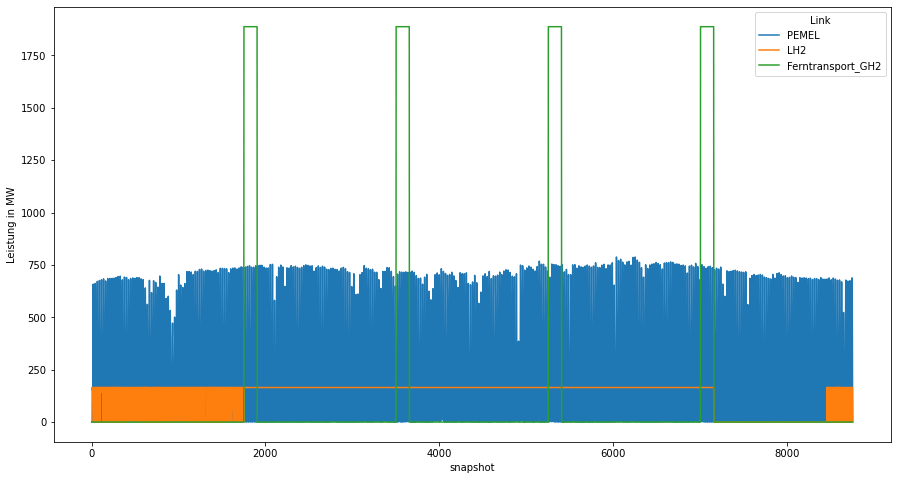

In [43]:
(network.links_t.p0).plot(figsize = (15,8), ylabel = 'Leistung in MW')

<AxesSubplot:xlabel='snapshot'>

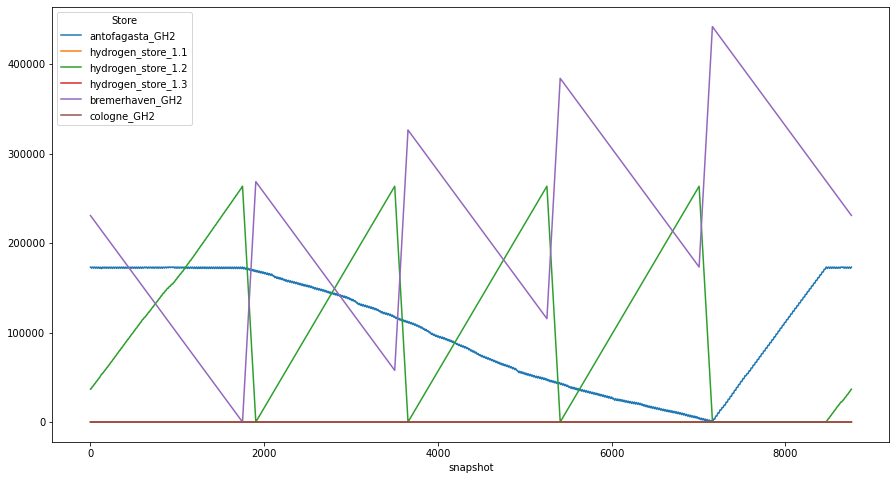

In [26]:
network.stores_t.e.plot(figsize = (15,8))

# Werkstatt

In [39]:
Speicherkosten = network.stores.e_nom_opt*network.stores.capital_cost
spez_Speicherkosten_MWh = Speicherkosten['antofagasta_GH2']/hydrogen_demand
spez_Speicherkosten_kg = spez_Speicherkosten_MWh/hydrogen_energy_content
spez_Speicherkosten_kg

0.908659356563518

In [ ]:
Kosten_Erzeugung = 